### Group members (first and last names):
- ####  *Abdelhak Kermia*


# Introduction
In this assignment, you'll dive into the world of Variational Autoencoders (VAEs) and latent space exploration using the MNIST dataset. You'll train a VAE to learn a meaningful representation of handwritten digits, visualize its latent space, and generate new digit images. Along the way, you'll experiment with sampling from the latent space and gain insights into how the model learns to generate realistic images. 

---
## How to pass the assignment?
Below, you will find the exercise questions. Each question that awards points is numbered and displays the available points in this format: **(0 pts)**.

### Answering Questions
- Provide your answers in the cell directly below each question.
- Use **Markdown** for text-based answers (in **English**).
- Use **code cells** for implementations.

### Critical Thinking Questions and Bonus Exercises
- Some questions are marked with a 🧠 (Critical Thinking) or a ⭐ (Bonus Exercise). These are for self-reflection and extra practice.
- They are **optional** and do **not** award any points.
- Answering them can help reinforce your understanding.

### Important Rules
- Only use the Python packages introduced in the assignment. Using unauthorized packages will result in **0 points** for the affected question.
- Follow dataset instructions carefully.
  - If no new dataset is mentioned, continue using the one from the previous task.
  - Using a different dataset than instructed will result in **0 points** for that question.
- All code must run correctly.
  - If your code does not execute, you will receive a **50% deduction** for that question.
  - Always test your code before submitting.
- Incorrect or incomplete answers receive **0 points**.
  - Partial credit may be awarded if the core idea is correct **and** the instructions are followed precisely.
  - If you do not follow the instructions, you will receive **0 points**, regardless of effort or length.
- Do not provide overly detailed or off-topic answers. Stay focused on what is asked. Extra information does not earn extra points.

### Important Notes
- Save your work frequently! (Ctrl + S)
- Before submitting, `Restart Session and Run All` cells to ensure everything works correctly.
- **You need at least 17 points out of 26 (66%) to pass ✅**
---

In [1]:
points = 26

In [2]:
# These are the packages you'll need today
# If you're running on a local environment, make sure everything you need is installed :)

# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import random

# PyTorch libraries for deep learning
import torch
from torchvision import datasets
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.utils import make_grid

# Other libraries
from tqdm.notebook import tqdm

# Set random seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

set_seed(0)

# Set up device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


# 1. Variational Autoencoder Fundamentals (14 points)
In the cell below, you will find the full implementation of a simple Variational Autoencoder (VAE). This code is available on Moodle for reference.

Take the time to carefully read and understand how this VAE is constructed, especially the role of the `encode`, `sample`, and `decode` methods. Understanding the way the latent variables are sampled using the reparameterization trick is **especially important**.

Once you are comfortable with the code, answer the following multiple-answer questions.

In [3]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=64, latent_dim=32):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

        self.latent_dim = latent_dim

    def encode(self, x):
        # `z` is the "hidden" representation of an input sample.
        z = self.encoder(x)

        # Use `z` to "predict" the mean and the logarithm of the
        # variance of the data. These two variables are used for
        # generating samples later on.
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)

        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # e^(1/2 * log(std^2))
        eps = torch.randn_like(std)  # eps ~ N(0, 1)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample(mu, logvar)
        x_tilde = self.decode(z)

        return x_tilde, mu, logvar


def vae_loss(x_tilde, x, mu, logvar):
    # This makes sure that we consider a "flattened" version of the
    # input data (notice that this is just a view, i.e. there is no
    # need for additional memory here).
    x = x.view(x_tilde.size())

    BCE = F.binary_cross_entropy(x_tilde, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(model, optimizer, train_loader, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        x = data.to(device)

        x_tilde, mu, logvar = model(x)

        loss = vae_loss(x_tilde, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    mean_loss = train_loss / len(train_loader.dataset)
    return mean_loss


def visualize_samples(model, device, num_samples=16, save=False):
    model.eval()
    with torch.no_grad():
        g = torch.Generator(device=device)
        g.manual_seed(42)
        z = torch.randn(num_samples, model.latent_dim, generator=g, device=device)

        # Read this as follows:
        # - Take the tensor and put it on the CPU (for visualisation)
        # - Reshape the latent space into an 1-channel image of
        # dimensions 28 by 28.
        samples = model.decode(z).cpu().view(-1, 1, 28, 28)

        grid = make_grid(samples, nrow=int(num_samples**0.5), padding=0)
        plt.figure(figsize=(5, 5))
        plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)), cmap="gray")
        plt.axis("off")
        plt.tight_layout(pad=0)
        if save:
            plt.savefig(f"/tmp/Epoch_{epoch:02d}.png")
        else:
            plt.show()
        

# This function was adapted from Deep Learning by Prof. Paolo Favaro, University of Bern
class RAMDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = [sample for sample in tqdm(dataset)]  # Load all the samples into RAM
        self.n = len(self.data)

    def __getitem__(self, ind):
        return self.data[ind]  # Return the sample without transformation

    def __len__(self):
        return self.n


Before training a model, let's test your understanding of foundational and advanced concepts around VAEs, generative modeling, and their components. For each topic, identify which statements are TRUE ✅ and which are FALSE ❌. Each question may have 1, 2, 3, or 4 correct answers.

- 4 correct answers: 2 points
- 3 correct answers: 1 point
- 2 or fewer correct answers: 0 points

💡 In Google Colab, you can easily add emojis to markdown cells by typing `:` followed by the emoji's name. For example, typing `:light-bulb` will display a light bulb emoji. This feature is also available as an extension in many IDEs.

❗ **TIP:** If a term is unfamiliar to you, look it up in [Google's ML Glossary](https://developers.google.com/machine-learning/glossary) for a simple explanation.

#### 1.1 **(2pts) What is generative modelling?**

 A. It involves learning the underlying distribution of the data to generate new samples. ✅

 B. It can be approached with models such as VAEs, GANs, and diffusion models. ✅

 C. It only applies to supervised learning problems. ❌

 D. It is used to model how data is generated in order to create new, similar data points. ✅

#### 1.2 **(2pts) You are shown a normal distribution curve. Which of the following help identify $\mu$ and $\sigma$?**

 A. $\mu$ is the total area under the curve.  ❌

 B. $\mu$ is the value at the peak of the curve. ✅

 C. $\sigma$ is always equal to 1 in any distribution. ❌

 D. $\sigma$ determines how wide the bell curve is. ✅

 #### 1.3 **(2pts) What are the main components of a standard autoencoder?**

 A. An encoder that maps inputs to a latent space.  ✅

 B. A decoder that reconstructs data from the latent space. ✅

 C. A loss function that compares input and output data. ✅

 D. A discriminator that distinguishes real from fake samples. ❌

#### 1.4 **(2pts) How does a VAE differ from a regular autoencoder?**

 A. A regular autoencoder uses a decoder, while a VAE does not. ❌

 B. A VAE does not compress input data into a smaller representation. ❌

 C. A VAE uses the same loss as a regular autoencoder, without any additional terms. ❌

 D. A VAE learns a distribution over the latent space, while a regular autoencoder learns fixed points. ✅

#### 1.5 **(2pts)  Which of the following statements describe a Variational Autoencoder (VAE)?**

 A. It learns a distribution over the latent space. ✅

 B. It uses adversarial training to improve sample quality. ❌

 C. The encoder predicts parameters $\mu$ and $log(\sigma ^2)$ for a Gaussian distribution. ✅

 D. After training, we can sample $z$ from $\mathcal{N}(0, I)$ and decode it into a new image. ✅

#### 1.6 **(2pts) What happens if you remove the randomness from the sample() function in a VAE (i.e., return `mu` instead of `mu + std * eps`)?**

 A. KL divergence would become more effective. ❌

 B. The model would behave like a regular autoencoder. ✅

 C. The decoder would always receive the same latent vector for each input, reducing output variability. ✅

 D. The model would generate more diverse samples. ❌

#### 1.7 **(2pts) Is it possible to implement a VAE using convolutional layers?**

 A. No, convolutional layers are not compatible with latent representations. ❌

 B. Yes, especially when working with image data. ✅

 C. Only the decoder can be made convolutional. ❌

 D. Convolutional VAEs often produce better reconstructions than fully connected ones. ✅

---

# 2. Coding (12 points)

### **Task:**  Train a VAE on MNIST, Visualize the Latent Space, and Generate New Images

In this coding section, you will work with the MNIST dataset, which contains images of handwritten digits (0–9). Your goals are:

1. Train a Variational Autoencoder (VAE) on the MNIST dataset.
2. Visualize the latent space, showing how different digits are organized.
3. Generate new digit images by sampling from the learned latent distribution.
4. This task will help you understand how VAEs encode data, structure the latent space, and allow for controlled image generation.


#### 2.1 **(2pts) Complete the Code to Train a VAE and Generate New Samples.**
- Use `latent_dim = 2` when creating the VAE model.
- Move the model to the correct device (e.g., cuda or cpu) using `.to(device)`.
- Use the `Adam` optimizer with a learning rate of `1e-3`.

In [4]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_dataset = datasets.MNIST(
    "./data", train=True, download=True, transform=transform
)

train_wrapper = RAMDatasetWrapper(train_dataset)

train_loader = DataLoader(train_wrapper, batch_size=128, shuffle=True, worker_init_fn=lambda _: np.random.seed(0))
# Seed variable/argument is not defined in the scope of the lambda here (or globally), Do we need worker_init_fn=lambda _: np.random.seed(seed) only 1 worker here by default ?, need different seed for each worker for "submodules:np, base python, ..." other than pytorch (base seed + worker_id)"

# TODO: Initialize the VAE model and the optimizer below
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
########################################################
with tqdm(range(30), unit="epoch") as progress_bar:
        for epoch in progress_bar:
            loss = train(model, optimizer, train_loader, device)
            progress_bar.set_postfix(loss=f"{loss:.04f}")
            

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 255kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.90MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


  0%|          | 0/60000 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?epoch/s]

#### **🧠 Do you know why we are setting `latent_dim = 2` in this experiment?**

We set `latent_dim = 2` to make it easy to visualize the latent space learned by the Variational Autoencoder (VAE). Since the latent representation of each input is a point (or distribution) in this space, using 2 dimensions allows us to:
- Plot the latent space directly using a 2D scatter plot, helping us see how the model organizes different digit classes.
- Interpret how similar digits cluster together (e.g., 3s and 8s might be close).
- Generate new images by sampling from specific locations in the 2D space and decoding them, making it easier to explore how latent values affect outputs.

While higher-dimensional latent spaces may better capture complex features and improve reconstruction quality, they are much harder to interpret visually.

#### 2.2 **(1pt) Call the `visualize_samples` function defined above.**

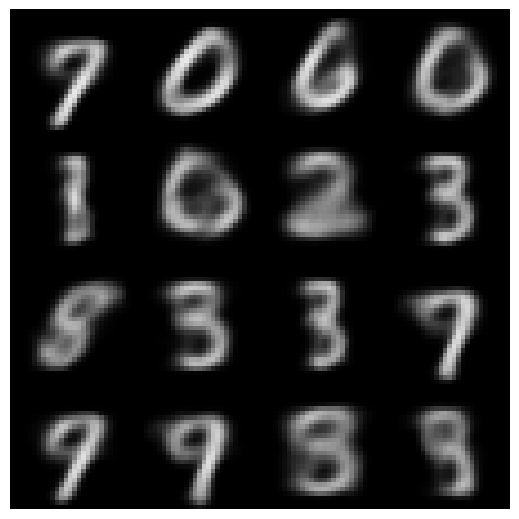

In [5]:
visualize_samples(model,device)

#### 2.3 **(2pts) What does the `visualize_samples` function do?**
*The same multiple-answer rules apply from the fundamentals section, meaning there could be one or more correct answers.*

 A. The function reconstructs images directly from the 60,000 training samples without generating new images. ❌

 B. It generates new images by sampling random latent vectors `z` from a normal distribution and decoding them using the trained VAE. ✅

 C. The function uses the encoder to reconstruct the training images from the dataset. ❌

 D. The function produces a grid of 28×28 grayscale images that resemble handwritten digits. ✅

#### 2.4 **(1pt) Call the `plot_latent_clusters` function defined below.**

In [6]:
def plot_latent_clusters(model, train_loader, device, num_batches=100):
    model.eval()
    zs = []
    labels = []

    with torch.no_grad():
        for i, (data, label) in enumerate(train_loader):
            if i >= num_batches:
                break
            data = data.view(-1, 784).to(device)
            mu, logvar = model.encode(data)
            z = model.sample(mu, logvar)
            zs.append(z.cpu())
            labels.append(label)

    zs = torch.cat(zs)
    labels = torch.cat(labels)

    # Plot with a unique color per class
    plt.figure(figsize=(8, 6))
    for digit in range(10):
        mask = labels == digit
        plt.scatter(zs[mask, 0], zs[mask, 1], label=str(digit), alpha=0.4, s=15)

    plt.legend(title="Digit")
    plt.legend(loc="upper right")
    plt.title("Latent Space Clusters (z ~ N(mu, σ²))")
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.xticks(np.arange(-5, 6, 1))
    plt.yticks(np.arange(-5, 6, 1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()


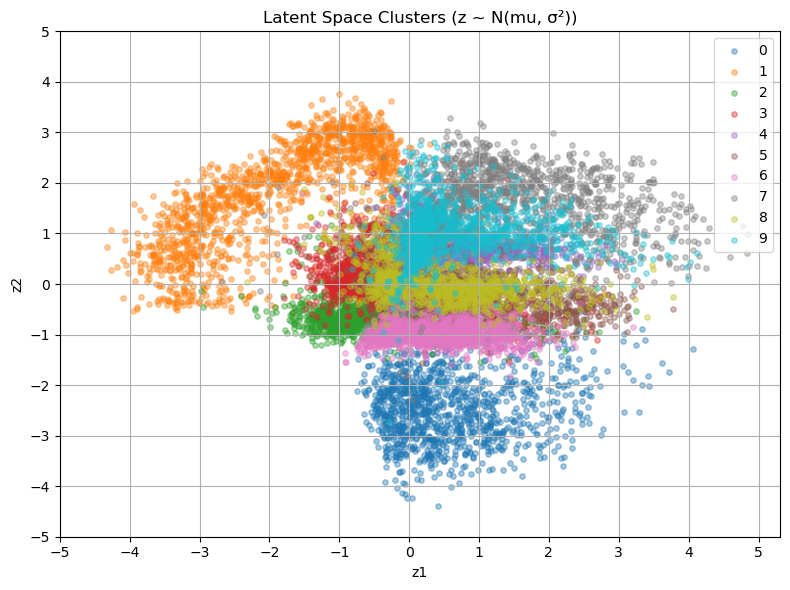

In [7]:
plot_latent_clusters(model,train_loader, device)

#### **🧠 Why do we reshape the data using `data.view(-1, 784)` before feeding it to the VAE?**
28x28*1 = 784 pixels, the latent vectors are treated as flat 1d tensor of length 784. Because we use FC linear layers (expect 1d input) in our encoders and decoders. (and not Conv2d for example who take and use 4D tensors of shape [B,C,H,W])

#### 2.5 **(2pts) What does the `plot_latent_clusters` function do?**
*The same multiple-answer rules apply from the fundamentals section.*

 A. It generates new images from random z values and plots their corresponding z-scores. ❌

 B. It uses the model's predicted mean (`mu`) and log variance (`logvar`) to sample a latent vector `z`. ✅

 C. It plots a 2D scatter plot of the latent vectors, colored by the digit label.  ✅

 D. It projects each input image from the training set into a 2D latent space using the VAE's encoder. ✅



#### 2.6 **(2pts) Interpret the Latent Space and Generate Digits from Chosen Coordinates.**
Look at the latent space plot produced by `plot_latent_clusters`.
- Create a dictionary named `latent_coords_by_digit` where:
    - The keys are digits (0–9).
    - The values are lists of latent coordinates [z1, z2] you choose based on the plot.
- Use the provided `generate_image_from_input_z` function to create and visualize digit images from your chosen latent coordinates.
- Then, use the provided `for` loop to decode each latent vector and display the generated digits in a grid layout.
- If a digit doesn't resemble the target class, briefly explain why you think that happened in a markdown cell.

In [8]:
latent_coords_by_digit={
    0: [0.0, -2.5],
    1: [-2.5, 1.5],
    2: [-1.0, -1.0],
    3: [-1.0, -0.0],
    4: [1.2, 0.7],
    5: [2, -0.5],
    6: [0.5, -1.0],
    7: [2, 2],
    8: [0.5, -0.3],
    9: [0, 1]
}

In [9]:
def generate_image_from_input_z(model, z, device, digit_size=28):
    model.eval()
    z_tensor = torch.tensor([z], dtype=torch.float32).to(device)
    with torch.no_grad():
        decoded_image = model.decode(z_tensor).view(digit_size, digit_size).cpu().numpy()
    return decoded_image


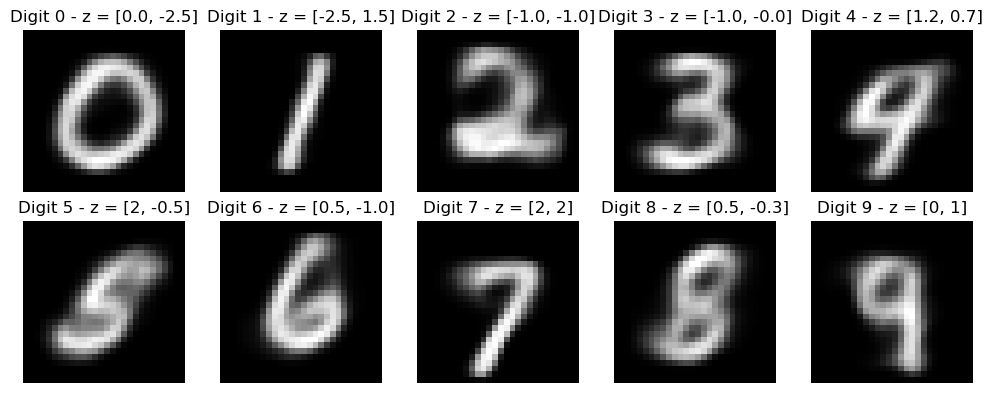

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, (label, z) in enumerate(latent_coords_by_digit.items()):
    row, col = divmod(i, 5)
    image = generate_image_from_input_z(model, z, device)
    axes[row, col].imshow(image, cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Digit {label} - z = {z}")

plt.tight_layout()
plt.show()


- Digit 2 has some artifacts from the number 3 distribution overlap/blending
- Digit 3 has some artifacts from the number 2 distribution due to some overlap.
- Digit 4 tends to look like a skewed 9, because the 4 distributions tend to overlap with the 9 and also the 7 distributions, where the upper part of the digit is a line (closed 4).
- Digit 5 is blurred: there is overlap with other digit distributions (6 and 8 numbers), and the 5 digits also seem to have a more diffuse distribution. Less well-defined / lower density.
- Digit 8 seems to have an artifact on the lower left due to overlap with the 2,3,6-digit distribution.
- The digits 6,7 also have some light artifacts.
** **
- Overall, many digits have some overlapping of their sample distribution near the center of the images:
    - There is no clear separation for some numbers such as 5,6,8 or 4,9,7, 2/3 (they share some visual features/traits), so they tend to blend in terms of shapes (visual features/traits), and this adds some noise (blur)/artifacts when the images are reconstructed. (latent vectors don't belong to only one class of digits in the latent space)

#### 2.7 **(2pts) Run the code below to generate the images using the provided latent coordinates `z`.**
- Write one sentence for each of the 4 generated images that describes what you observe.

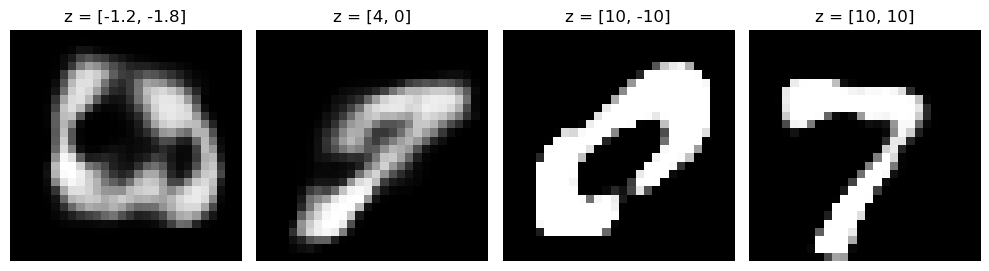

In [11]:
hallucinated_digits = {
    "h1": [-1.2, -1.8],
    "h2": [4, 0],
    "h3": [10, -10],
    "h4": [10, 10]
}

fig, axes = plt.subplots(1, 4, figsize=(10, 4))
for i, (label, z) in enumerate(hallucinated_digits.items()):
    image = generate_image_from_input_z(model, z, device)
    axes[i].imshow(image, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"z = {z}")

plt.tight_layout()
plt.show()

- On the left bottom (-1.2,-1.8): we can see, the mix of the number 2 form and some of the 6 and maybe 0 number form. The form is blurry: blurry edges
- On the center right( 4,0): we deduce a not closed 9 inclined with some 5,7 form influences. The form is blurry: blurry edges
- On the bottom right (10,-10): we can observe the number 0 form inclined and open looks like a mix with a 6 form. The form is well-defined: sharp edges
- On the top right (10,10): the number 7 form seems to be a little bit shifted to the bottom edge, and a top is a bit round like the top of a 9. The form is well-defined: sharp edges


In [14]:
points

26

#### **⭐ BONUS: Modify the Arguments to Visualize the Latent Space Differently.**

As a bonus exercise, you can modify the arguments in the `plot_latent_space` function below to explore the latent space in different ways. Here are a few suggestions on how to experiment with the function:

1. **Change the Scale:**
    - Modify the `scale` parameter to see how the latent space visualization changes. A larger `scale` will expand the grid, while a smaller `scale` will zoom in on a more localized region of the latent space.
    - **Example:** Try `scale=3.0` or `scale=1.0` and observe how the grid of generated digits changes.

2. **Increase or Decrease the Grid Size:**
    - Change the `n` parameter to control the number of grid points along each axis. A larger `n` will create a more detailed visualization, while a smaller `n` will show a more sparse representation.
    - **Example:** Try `n=30` or `n=10` to see the effect on the grid resolution.

3. **Explore Different Latent Space Regions:**
    - Adjust the `grid_x` and `grid_y` values manually to explore specific regions of the latent space. This can help highlight interesting areas of the space that may produce more diverse or realistic images.
    - **Example:** Try using a narrower range like `grid_x = np.linspace(0, 2, n)` and `grid_y = np.linspace(1, 3, n)` to focus on the latent space region corresponding to the digit 4, or experiment with other digit ranges to visualize how different digits are distributed.

In [12]:
def plot_latent_space(model, device, scale=2.0, n=25, digit_size=28, figsize=8, title=""):

    assert model.latent_dim == 2, "Latent space must be 2D to plot this grid."

    # Generate grid coordinates
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(scale, -scale, n)

    figure = np.zeros((digit_size * n, digit_size * n))

    model.eval()
    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
                digit = model.decode(z_sample).view(digit_size, digit_size).cpu().numpy()
                figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

    # Plot
    plt.figure(figsize=(figsize, figsize))
    scale_range = np.arange(digit_size // 2, n * digit_size + digit_size // 2, digit_size)
    plt.xticks(scale_range, np.round(grid_x, 1))
    plt.yticks(scale_range, np.round(grid_y, 1))
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.imshow(figure, cmap="gray")
    plt.title("Decoded Digits Across 2D Latent Space: " + title)
    plt.tight_layout()
    plt.show()

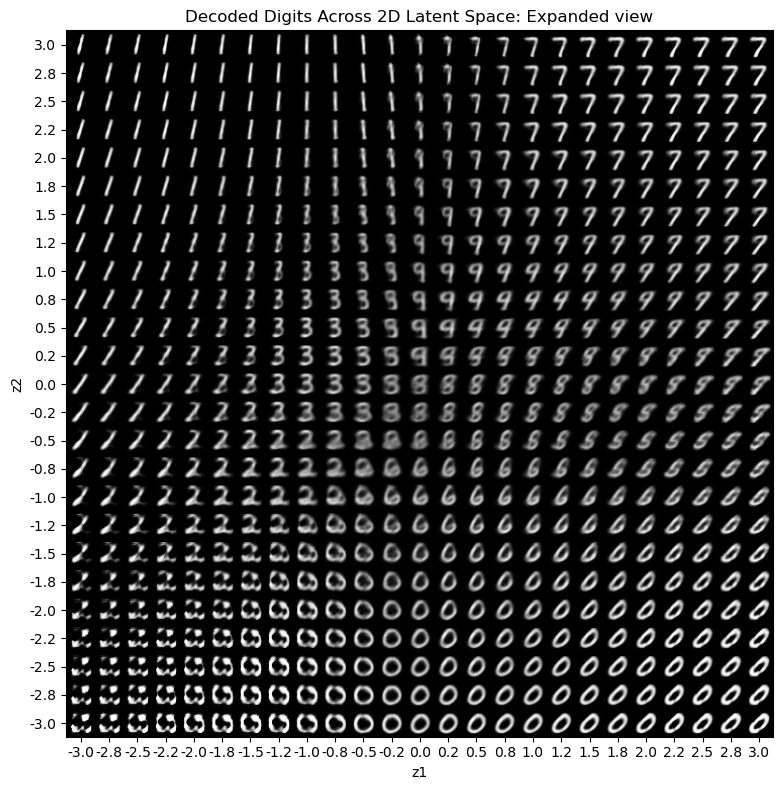

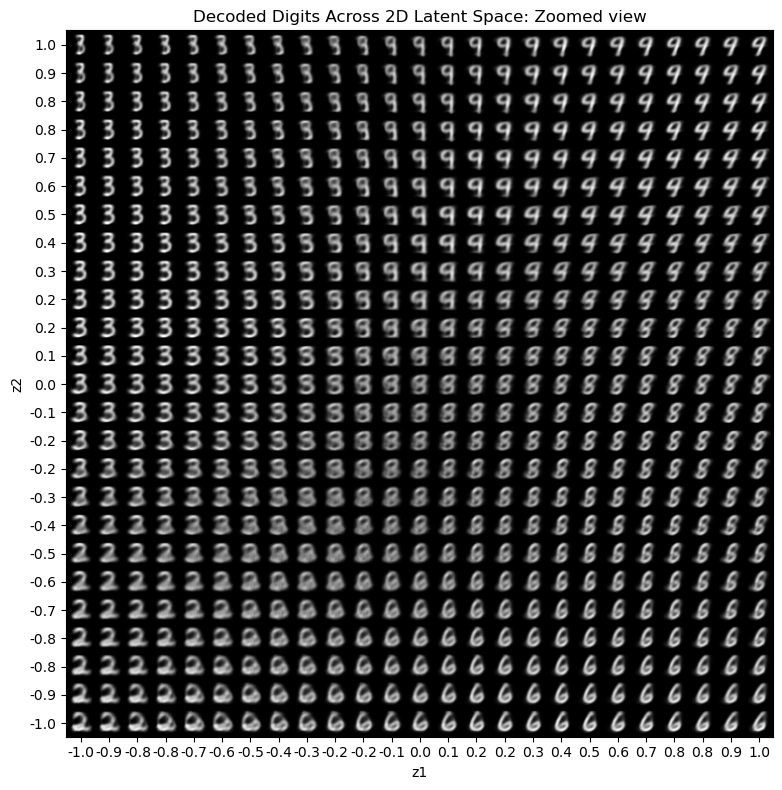

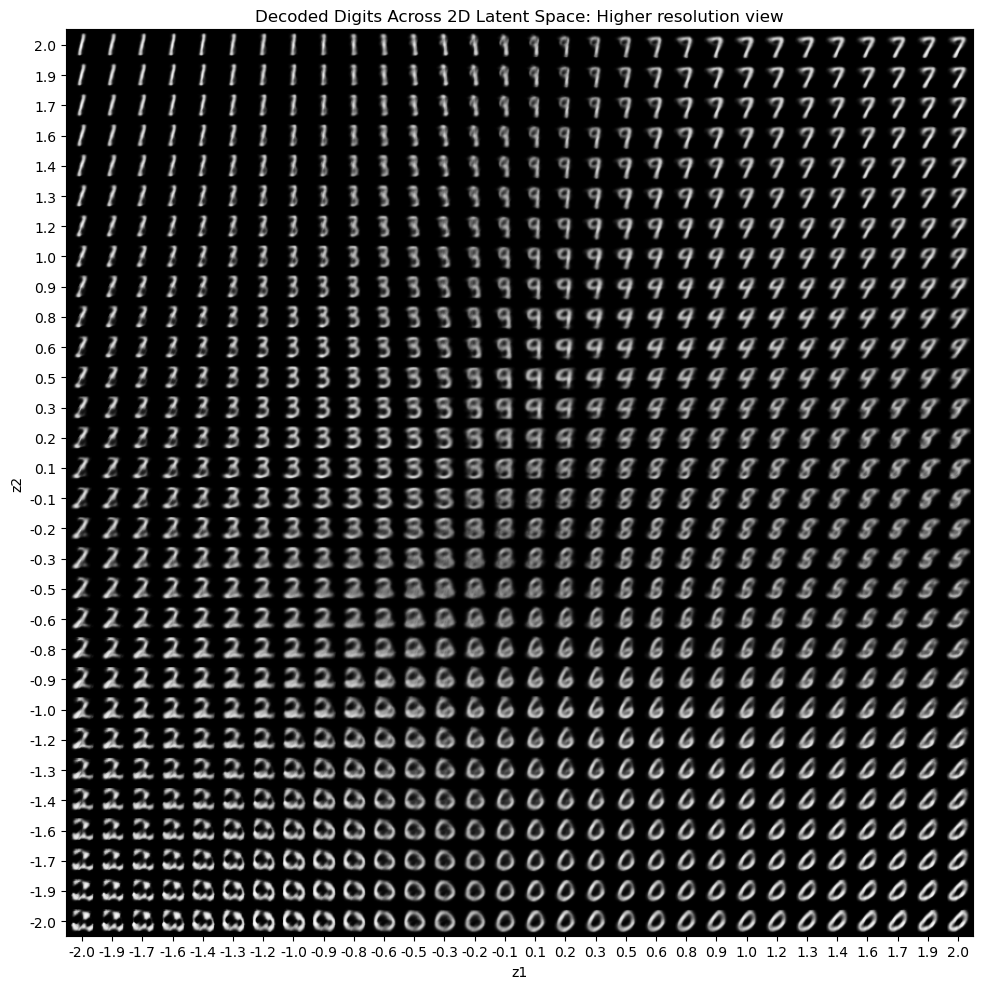

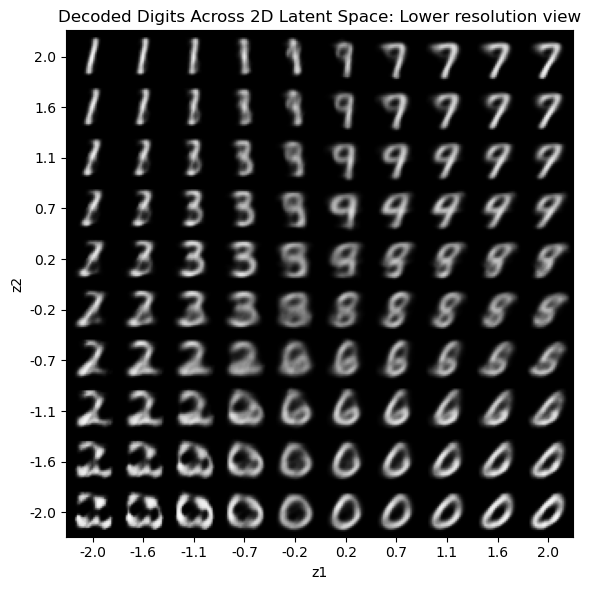

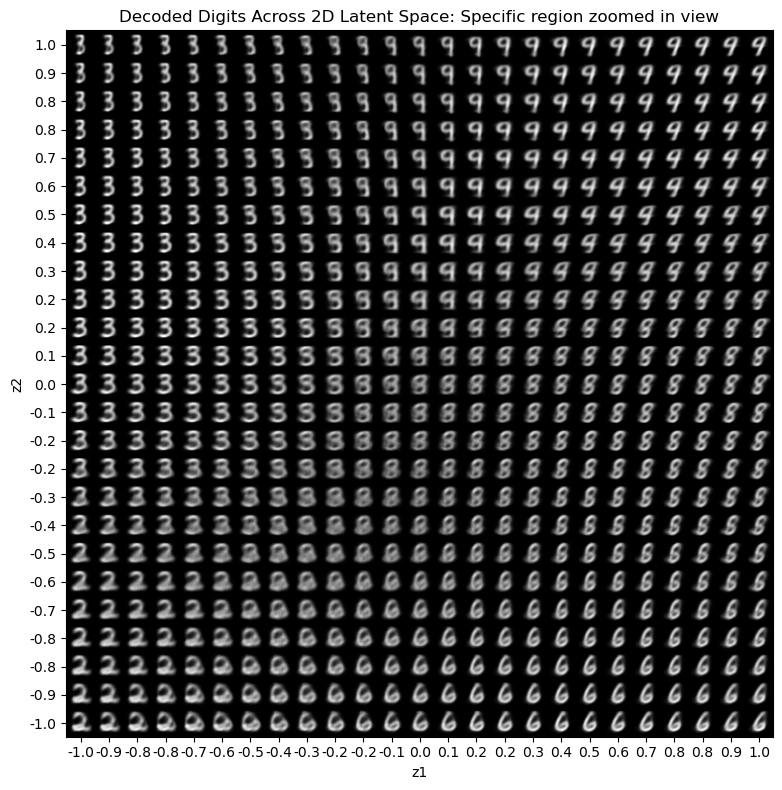

In [13]:
plot_latent_space(model, device, scale=3.0, n=25, digit_size=28, figsize=8,title="Expanded view")
plot_latent_space(model, device, scale=1.0, n=25, digit_size=28, figsize=8,title="Zoomed view")
plot_latent_space(model, device, scale=2.0, n=30, digit_size=28, figsize=10,title="Higher resolution view")
plot_latent_space(model, device, scale=2.0, n=10, digit_size=28, figsize=6,title="Lower resolution view")
# Focus on a specific latent region, possibly representing '4'
grid_x = np.linspace(0, 2, 25)
grid_y = np.linspace(1, 3, 25)
plot_latent_space(model, device, scale=1.0, n=25, digit_size=28, figsize=8,title="Specific region zoomed in view")

#### **⭐ BONUS: Observe How Samples Evolve During Training.**
Run the VAE training script provided on Moodle on your local machine. During training, the model will periodically generate and save sample images. Watch how the quality and clarity of the generated digits change from the first few epochs to the final ones.

---
Congratulations on completing this assignment! 🎉

By training and experimenting with the VAE on the MNIST dataset, you’ve learned how the model generates realistic images and visualized how the latent space is structured.

Keep exploring and experimenting with the latent space, and don't hesitate to try new ways to modify the parameters for more insights! 🚀💡